The following notebook aims to utilize causal inference to determine whether the pet ban affects the property prices in the given area

The dataset used in this project contains 1903 entries of the various housing information of the properties located in Dubai, United Arab Emirates

Upon initial inspection of the dataset (see the "data exploration" section), we can notice that a lot of houses in Dubai (a place that is known for its luxurious housing market) do not allow pets. This could be interpreted in a number of ways. For example, the ban might make the property look more luxurious. On the other hand, people might be discouraged to spend a considerable sum of money on the real estate where they cannot even bring their pets. In order to solve this puzzle, we implore scientific tools to compare means of the properties that allow pets with the means of the properties that have a pet ban, and evaluate whether the difference is significant and constant.

In [ ]:
# NOTE: this notebook was written in google colab due to the multiple errors that appeared during the installation of causalml. Therefore, it is highly recommended
# that the notebook is run in google colab. Otherwise, it might not work.

In [ ]:
# first, let's start with trying to import common data science packages
import numpy as np
import os
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from scipy import stats

In [ ]:
#installing causal ml
!pip install causalml

     |████████████████████████████████| 401 kB 5.2 MB/s 
     |████████████████████████████████| 326 kB 35.3 MB/s 
     |████████████████████████████████| 1.8 MB 43.8 MB/s 
     |████████████████████████████████| 713 kB 55.3 MB/s 
  Created wheel for causalml: filename=causalml-0.12.1-cp37-cp37m-linux_x86_64.whl size=1036199 sha256=44534e6612ec12d7fd9258f2360d1d3e9eae9b4941a29a00b6a729502185be71
  Stored in directory: /root/.cache/pip/wheels/c2/a7/ff/f853b7e4d8d4d9b68df70333a06d6a01fd96fb086e2922ace1
  Created wheel for shap: filename=shap-0.37.0-cp37-cp37m-linux_x86_64.whl size=465066 sha256=759ad33d7cc079cbb00570b0f2c4488fe7225c84b3ad2ec97aef251f3b0605bd
  Stored in directory: /root/.cache/pip/wheels/df/b8/18/2c0a6105152e62dd9a7cf47b5110b9cedb0c8739babdef64b7
Successfully built causalml shap


In [ ]:
#now, let us import causalml, xgboost and related packages
import causalml
from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor
from causalml.inference.meta import BaseRRegressor
from xgboost import XGBRegressor


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#importing the dataset
dubai = pd.read_csv('property.csv', index_col=0)
dubai.head()

#here, we notice that similar houses might have different pet policies:

id          neighborhood  ...  view_of_water  walk_in_closet
0  5528049.0         Palm Jumeirah  ...           True           False
1  6008529.0         Palm Jumeirah  ...           True           False
2  6034542.0  Jumeirah Lake Towers  ...           True            True
3  6326063.0       Culture Village  ...          False           False
4  6356778.0         Palm Jumeirah  ...           True           False

[5 rows x 38 columns]

Look at the data structure

In [ ]:
dubai.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1905 entries, 0 to 1904
Data columns (total 38 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   1810 non-null   float64
 1   neighborhood         1905 non-null   object 
 2   latitude             1905 non-null   float64
 3   longitude            1905 non-null   float64
 4   price                1905 non-null   int64  
 5   size_in_sqft         1676 non-null   float64
 6   price_per_sqft       1905 non-null   float64
 7   no_of_bedrooms       1810 non-null   float64
 8   no_of_bathrooms      1734 non-null   float64
 9   quality              1905 non-null   object 
 10  maid_room            1905 non-null   bool   
 11  unfurnished          1905 non-null   bool   
 12  balcony              1905 non-null   bool   
 13  barbecue_area        1905 non-null   bool   
 14  built_in_wardrobes   1905 non-null   bool   
 15  central_ac           1905 non-null   b

In [ ]:
dubai["neighborhood"].value_counts()


Downtown Dubai                       302
Dubai Marina                         288
Jumeirah Village Circle              200
Palm Jumeirah                        178
Jumeirah Beach Residence             116
Business Bay                          97
Jumeirah Lake Towers                  70
Dubai Hills Estate                    53
The Views                             47
Jumeirah                              39
Dubai Creek Harbour (The Lagoons)     38
Mohammed Bin Rashid City              31
DIFC                                  31
Greens                                30
Dubai Harbour                         30
Motor City                            27
Town Square                           27
Dubai Sports City                     25
Al Furjan                             23
DAMAC Hills                           21
Old Town                              17
Meydan                                17
City Walk                             14
Umm Suqeim                            13
Dubai Silicon Oa

In [ ]:
dubai["quality"].value_counts()


Medium    1146
Low        544
High       134
Ultra       81
Name: quality, dtype: int64

In [ ]:
dubai.describe()


id     latitude  ...  no_of_bedrooms  no_of_bathrooms
count  1.810000e+03  1905.000000  ...     1810.000000      1734.000000
mean   7.572245e+06    25.116538  ...        1.792818         2.511534
std    1.946124e+05     0.062647  ...        0.947286         1.056202
min    5.528049e+06    24.865992  ...        0.000000         1.000000
25%    7.559838e+06    25.072791  ...        1.000000         2.000000
50%    7.630968e+06    25.096700  ...        2.000000         2.000000
75%    7.670067e+06    25.188130  ...        2.000000         3.000000
max    7.706643e+06    25.273623  ...        5.000000         6.000000

[8 rows x 8 columns]

Data exploration and visualization

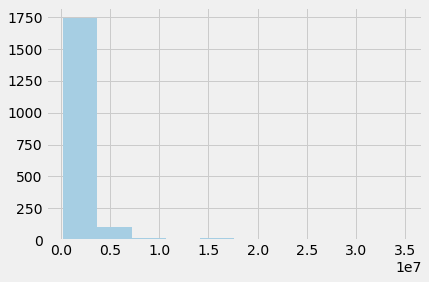

In [ ]:
dubai["price"].hist()


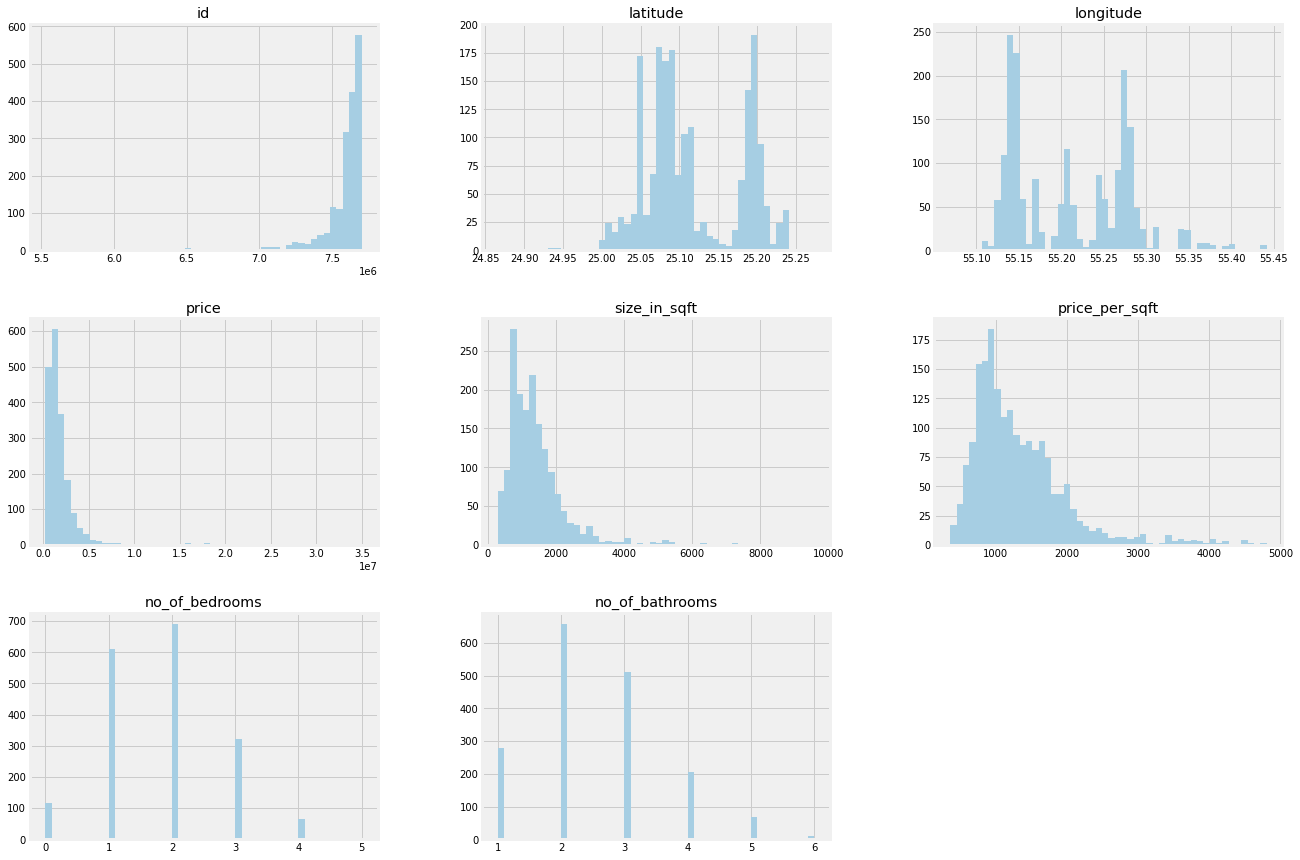

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
dubai.hist(bins=50, figsize=(20,15))
plt.show()

Let's take a look at the relationship between the prices and the neighborhoods

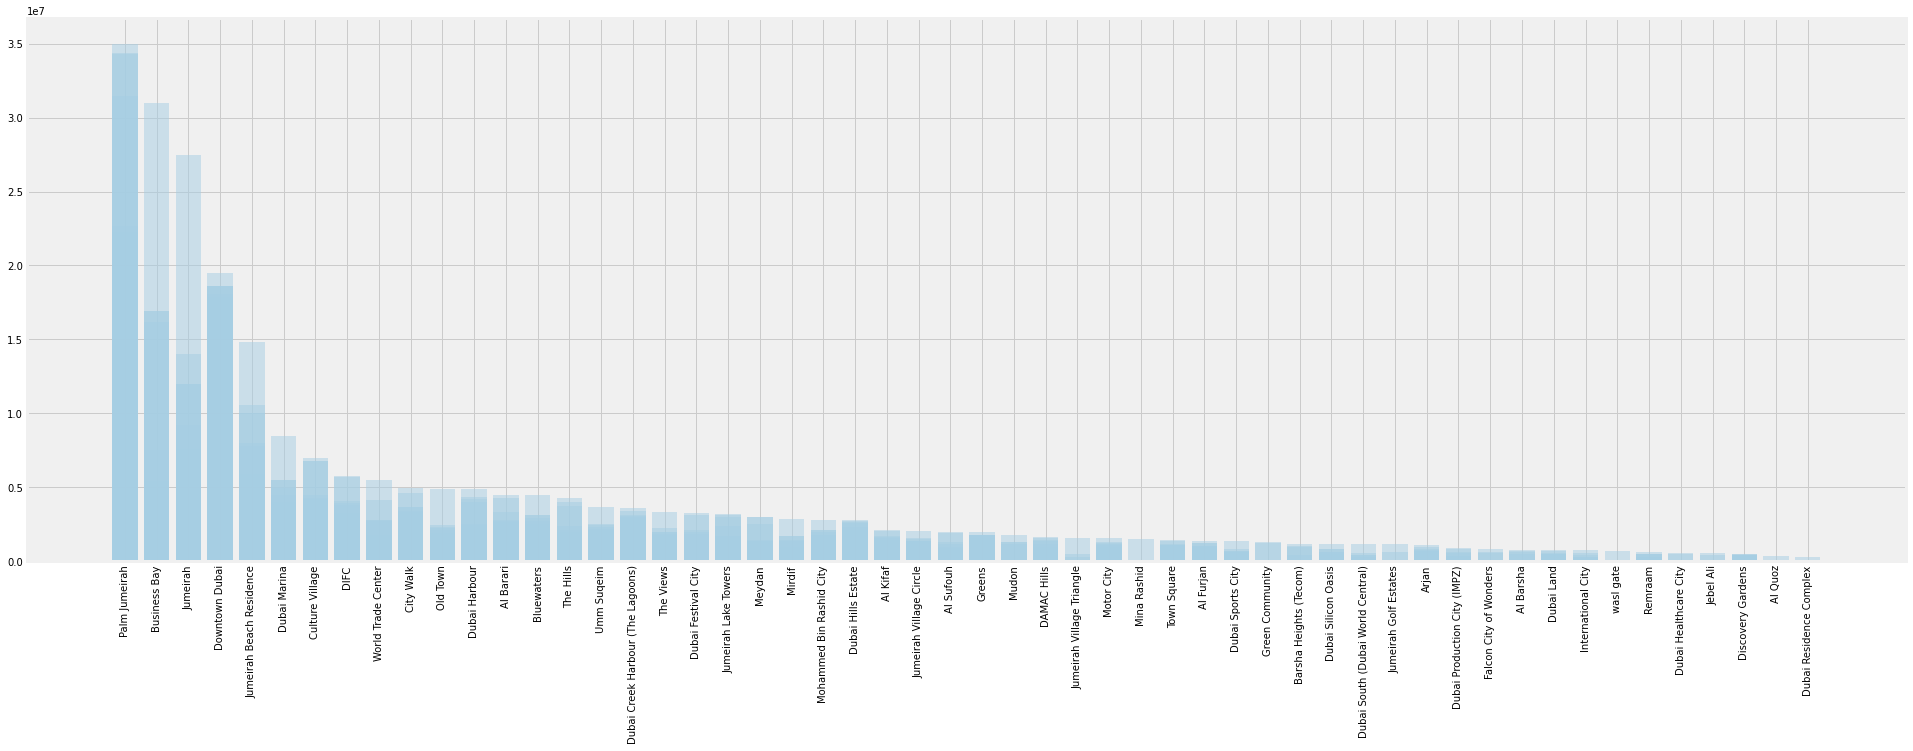

In [ ]:
neighborhood_price = dubai[['price', 'neighborhood']].sort_values(by=['price'], ascending = False)

plt.figure(figsize = (30, 10))
plt.bar(neighborhood_price.neighborhood, neighborhood_price.price, align='center', alpha=0.5)
plt.xticks(rotation='vertical')
plt.show()

Now, let's visualize relationship between the price per square footage and the neighborhoods

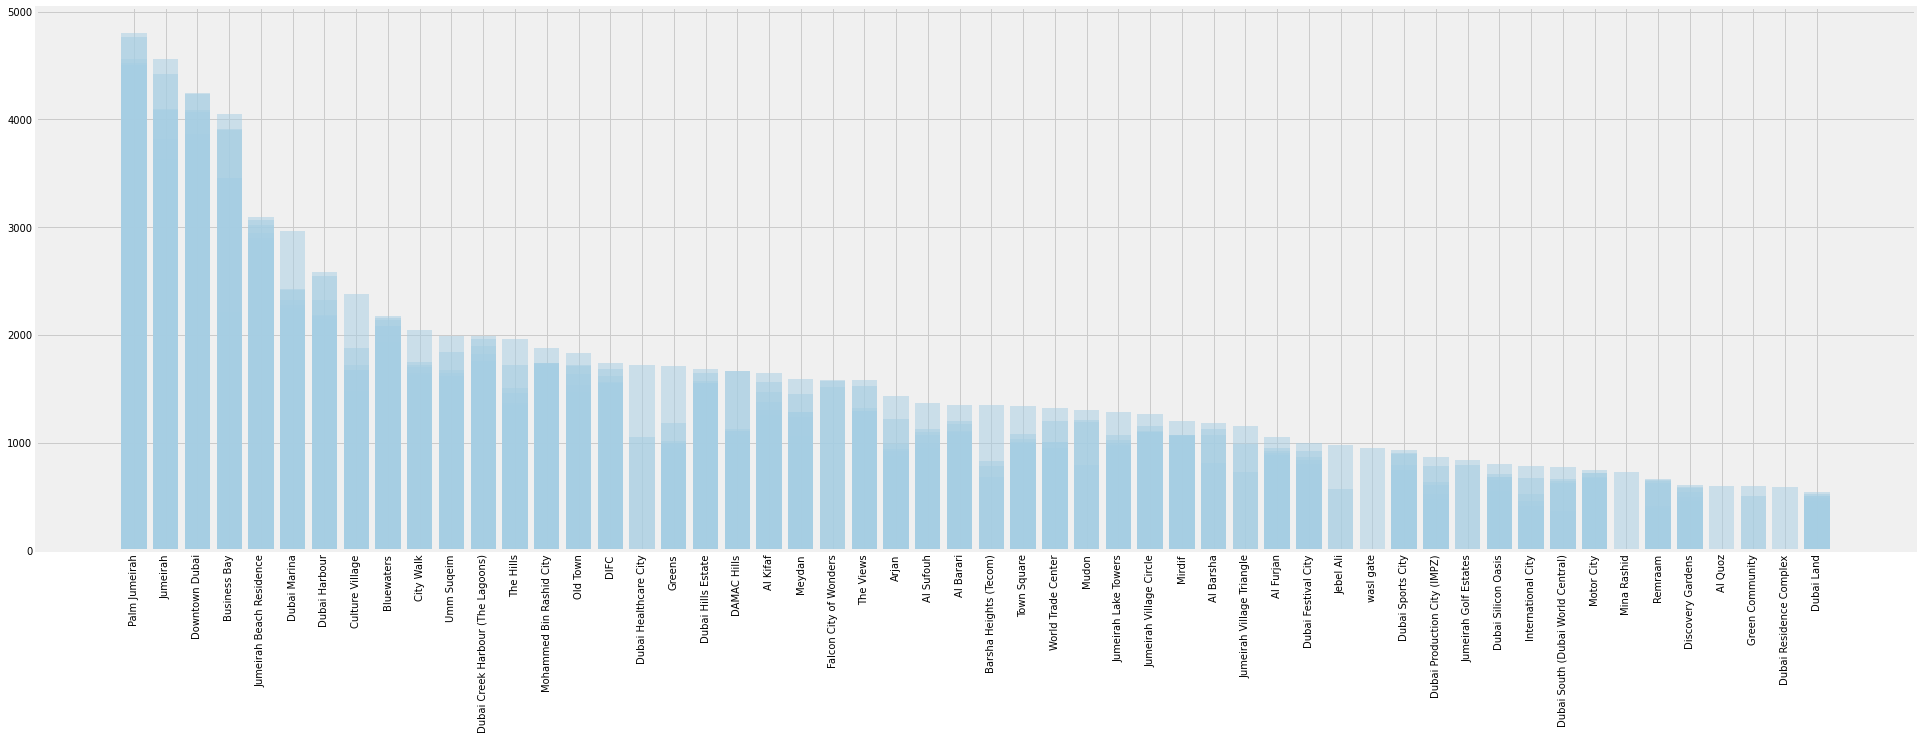

In [ ]:
neighborhood_price_per_sqft = dubai[['price_per_sqft', 'neighborhood']].sort_values(by=['price_per_sqft'], ascending = False)

plt.figure(figsize = (30, 10))
plt.bar(neighborhood_price_per_sqft.neighborhood, neighborhood_price_per_sqft.price_per_sqft, align='center', alpha=0.5)
plt.xticks(rotation='vertical')
plt.show()

Further Visualization

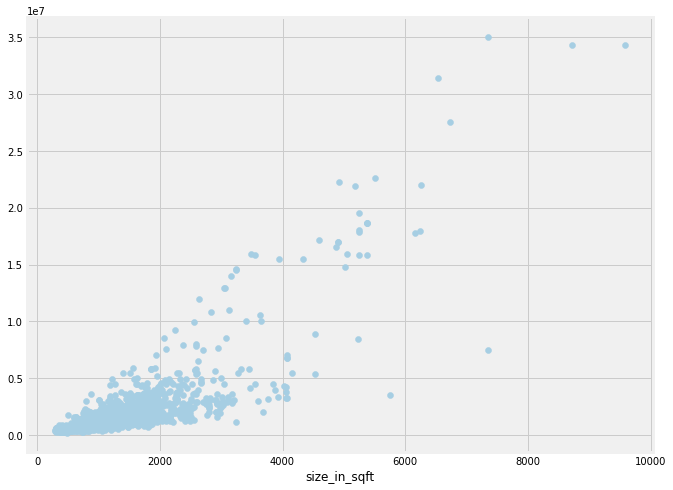

In [ ]:
#relationship between the size in square feet and the price
plt.figure(figsize = (10, 8))

feature = 'size_in_sqft'
plt.scatter(dubai[feature], dubai['price'])
plt.xlabel('size_in_sqft')
plt.grid(True)

Visualizing the observations on the map can help us get a more practical perspective on the given dataset

In [ ]:
# note: geopy and folium were installed through pip install in the command prompt of Anaconda
from geopy.geocoders import Nominatim
import folium
from folium.plugins import HeatMap

address = 'Dubai, United Arab Emirates'
geolocator = Nominatim(user_agent="data_regress_project")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

data = dubai[['latitude', 'longitude', 'price']].values

# create map of Dubai using latitude and longitude values
map_dubai_re = folium.Map(location = [latitude, longitude], control_scale=True, zoom_start = 12)

# add markers to map
for lat, lng, neighborhood in zip(dubai['latitude'], dubai['longitude'], dubai['neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius = 2,
        popup=label,
        color='b',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=1,
        parse_html=False).add_to(map_dubai_re)  
    
radius = 15
hm = HeatMap(
    data,
    radius=radius,
    blur=30
)
hm.add_to(map_dubai_re)
    
map_dubai_re

Looking for correlations

In [ ]:
corr_matrix = dubai.corr()


In [ ]:
corr_matrix["price"].sort_values(ascending=False)


price                  1.000000
size_in_sqft           0.808354
price_per_sqft         0.705538
no_of_bedrooms         0.510942
no_of_bathrooms        0.497290
private_pool           0.325857
latitude               0.206775
concierge              0.113217
maid_room              0.109675
private_gym            0.089794
view_of_water          0.088400
private_jacuzzi        0.073879
private_garden         0.049032
unfurnished            0.029904
built_in_wardrobes     0.026963
maid_service           0.019678
central_ac             0.016365
view_of_landmark       0.015263
covered_parking        0.011251
balcony                0.006558
walk_in_closet        -0.003760
shared_spa            -0.003985
longitude             -0.015395
kitchen_appliances    -0.021120
study                 -0.023678
id                    -0.037275
shared_gym            -0.058010
barbecue_area         -0.079268
shared_pool           -0.084076
vastu_compliant       -0.084158
security              -0.085007
networke

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff8e7763b50>,
      dtype=object)

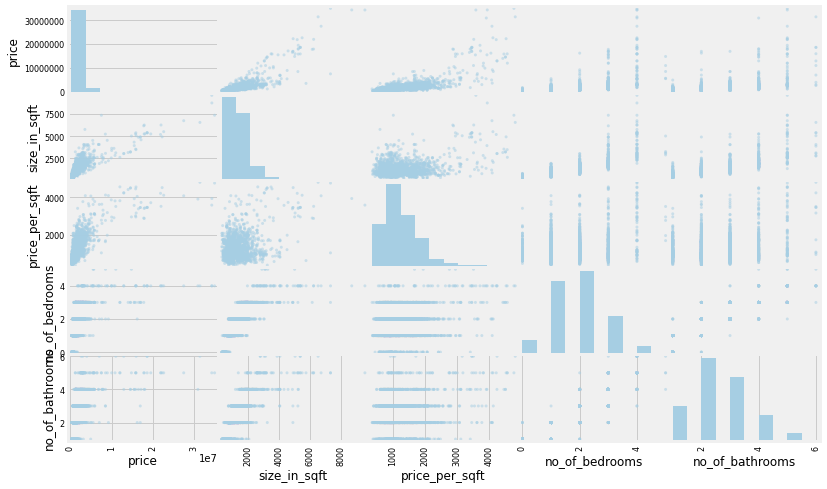

In [ ]:
from pandas.plotting import scatter_matrix

attributes = ["price", "size_in_sqft", "price_per_sqft",
              "no_of_bedrooms","no_of_bathrooms"]
scatter_matrix(dubai[attributes], figsize=(12, 8))

In [ ]:
corr_matrix.style.background_gradient(cmap='coolwarm')


Data Cleaning

In [ ]:
#organizing numerical variables:

dubai_num = dubai.iloc[:,0:9]

dubai_num = dubai_num.drop(columns = ['neighborhood'])

dubai_num.head()


id   latitude  ...  no_of_bedrooms  no_of_bathrooms
0  5528049.0  25.113208  ...             1.0              2.0
1  6008529.0  25.106809  ...             2.0              2.0
2  6034542.0  25.063302  ...             3.0              5.0
3  6326063.0  25.227295  ...             2.0              3.0
4  6356778.0  25.114275  ...             0.0              1.0

[5 rows x 8 columns]

In [ ]:
# Drop unsuitable variables:
dubai_drop = dubai_num

# Drop ID column:
dubai_drop = dubai_drop.drop(columns = ["id"])

# Now, let's go back to the correlations.

# According to the table above, we have to drop either number of bedrooms or number of bathrooms. Since the former also 
# has a higher correlation with the target variable, we drop the latter:
dubai_drop = dubai_drop.drop(columns = ["no_of_bathrooms"])

# drop size in square feet: 
dubai_drop = dubai_drop.drop(columns = ["size_in_sqft"])

In [ ]:
print(dubai_drop.isnull().sum())


latitude           0
longitude          0
price              0
price_per_sqft     0
no_of_bedrooms    95
dtype: int64


Now, let's deal with the rest of the columns that have missing data

In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
imputer.fit(dubai_drop)

# check median values calculation
diff = imputer.statistics_ - dubai_drop.median().values
print(diff)
print("median calculation OK")

# imputing medians
X = imputer.transform(dubai_drop)
dubai_imputed_num = pd.DataFrame(X, columns=dubai_drop.columns,
                          index=dubai_drop.index)

[0. 0. 0. 0. 0.]
median calculation OK


In [ ]:
print(dubai_imputed_num.isnull().sum())


latitude          0
longitude         0
price             0
price_per_sqft    0
no_of_bedrooms    0
dtype: int64


Now, that the numerical variables are dealt with, let's move onto the categorical variables


In [ ]:
dubai_cat = dubai.iloc[:,1:]
dubai_cat = dubai_cat.drop(columns = ['latitude','longitude','size_in_sqft','price_per_sqft','no_of_bedrooms','no_of_bathrooms','price'])
dubai_cat.head()

neighborhood quality  ...  view_of_water  walk_in_closet
0         Palm Jumeirah  Medium  ...           True           False
1         Palm Jumeirah  Medium  ...           True           False
2  Jumeirah Lake Towers  Medium  ...           True            True
3       Culture Village     Low  ...          False           False
4         Palm Jumeirah  Medium  ...           True           False

[5 rows x 30 columns]

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
dubai_cat_encoded = ordinal_encoder.fit_transform(dubai_cat)
dubai_cat_encoded[:]

array([[46.,  2.,  0., ...,  0.,  1.,  0.],
       [46.,  2.,  0., ...,  0.,  1.,  0.],
       [36.,  2.,  1., ...,  1.,  1.,  1.],
       ...,
       [16.,  2.,  1., ...,  0.,  0.,  0.],
       [37.,  2.,  0., ...,  0.,  1.,  1.],
       [36.,  0.,  0., ...,  0.,  1.,  0.]])

In [ ]:
columns = dubai_cat.columns
type(columns)

pandas.core.indexes.base.Index

In [ ]:
datacat = pd.DataFrame(dubai_cat_encoded, columns = columns)
datacat.head(5)

neighborhood  quality  ...  view_of_water  walk_in_closet
0          46.0      2.0  ...            1.0             0.0
1          46.0      2.0  ...            1.0             0.0
2          36.0      2.0  ...            1.0             1.0
3          11.0      1.0  ...            0.0             0.0
4          46.0      2.0  ...            1.0             0.0

[5 rows x 30 columns]

In [ ]:
# Let us set the boolean variable "pets_allowed" as treatment
dubai_concat = pd.concat([dubai_imputed_num, dubai[["pets_allowed"]], datacat], axis=1)

# if "pets_allowed" == True, label it as 1, otherwise 0
dubai_concat["treatment"] = np.where(dubai["pets_allowed"]==True, 1, 0)
dubai_prepared = dubai_concat.drop(columns = ["pets_allowed"])



In [ ]:
dubai_prepared.head(5)

latitude  longitude      price  ...  view_of_water  walk_in_closet  treatment
0  25.113208  55.138932  2700000.0  ...            1.0             0.0          1
1  25.106809  55.151201  2850000.0  ...            1.0             0.0          0
2  25.063302  55.137728  1150000.0  ...            1.0             1.0          0
3  25.227295  55.341761  2850000.0  ...            0.0             0.0          1
4  25.114275  55.139764  1729200.0  ...            1.0             0.0          0

[5 rows x 35 columns]

CausalML

After exploration and pre-processing, we are ready to use causal inference to compare the means of the data with and without treatment

In [ ]:
pd.Series(dubai_prepared['treatment']).value_counts(normalize=True)

0    0.702362
1    0.297638
Name: treatment, dtype: float64

In [ ]:
dubai_prepared.head(5)

latitude  longitude      price  ...  view_of_water  walk_in_closet  treatment
0  25.113208  55.138932  2700000.0  ...            1.0             0.0          1
1  25.106809  55.151201  2850000.0  ...            1.0             0.0          0
2  25.063302  55.137728  1150000.0  ...            1.0             1.0          0
3  25.227295  55.341761  2850000.0  ...            0.0             0.0          1
4  25.114275  55.139764  1729200.0  ...            1.0             0.0          0

[5 rows x 35 columns]

In [ ]:
#setting up X and y variables
X = dubai_prepared.drop(columns = ["treatment","price"])
treatment = dubai_prepared['treatment']
y = dubai_prepared['price']

In [ ]:
#utilizing LRSRegressor (LR) for ATE
lr = LRSRegressor()
te, lb, ub = lr.estimate_ate(X, treatment, y)
print('Average Treatment Effect (Linear Regression): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

Average Treatment Effect (Linear Regression): 141527.97 (-36558.28, 319614.23)


In [ ]:
X.shape

(1905, 33)

In [ ]:
#utilizing XGBoost for ATE
xg = XGBTRegressor(random_state=42)
te, lb, ub = xg.estimate_ate(X, treatment, y)
print('Average Treatment Effect (XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

[03:19:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:19:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Average Treatment Effect (XGBoost): 318883.19 (199109.10, 438657.29)


In [ ]:
#utilizing MPLTRegressor (Neural Network) for ATE
nn = MLPTRegressor(hidden_layer_sizes=(10, 10),
 learning_rate_init=.1,
 early_stopping=True,
 random_state=42)
te, lb, ub = nn.estimate_ate(X, treatment, y)
print('Average Treatment Effect (Neural Network (MLP)): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

Average Treatment Effect (Neural Network (MLP)): -289982.49 (-492370.05, -87594.92)


In [ ]:
#utilizing BaseXRegressor (using XGBoost) for ATE
xl = BaseXRegressor(learner=XGBRegressor(random_state=42))
te, lb, ub = xl.estimate_ate(X, treatment, y)
print('Average Treatment Effect (BaseXRegressor using XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

[03:19:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:19:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:19:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:19:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Average Treatment Effect (BaseXRegressor using XGBoost): 255094.78 (163430.83, 346758.73)


In [ ]:
#utilizing BaseRRegressor (using XGBoost) for ATE
rl = BaseRRegressor(learner=XGBRegressor(random_state=42))
te, lb, ub = rl.estimate_ate(X=X, treatment=treatment, y=y)
print('Average Treatment Effect (BaseRRegressor using XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

[03:20:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Average Treatment Effect (BaseRRegressor using XGBoost): -17190.28 (-19468.09, -14912.47)


Overall, ATE results are inconsistent. For example, LRSRegressor states that houses without pet policy are 141527 cheaper than houses with pet ban. However, MPLTRegressor shows the opposite - property without the ban is 289982 more expensive on average. Other methods add more inconsistency into the final result. Based on this fact, we can say that there is no clear link between price of the property and its pet policy.

In [ ]:
from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor

In [ ]:
from lightgbm import LGBMRegressor

In [ ]:
w_multi = np.array(['treated' if i==1 else 'control' for i in dubai_prepared.treatment])
slearner = BaseSRegressor(LGBMRegressor(), control_name='control')
slearner.estimate_ate(X, w_multi, y)
slearner_tau = slearner.fit_predict(X, w_multi, y)

In [ ]:
model_tau_feature = RandomForestRegressor() # specify model for model_tau_feature
feature_names = X.columns
slearner.get_importance(X=X, tau=slearner_tau, model_tau_feature=model_tau_feature,
 normalize=True, method='auto', features=feature_names)

{'treated': price_per_sqft         0.269087
 longitude              0.215570
 no_of_bedrooms         0.137814
 neighborhood           0.120352
 latitude               0.058719
 childrens_play_area    0.054836
 maid_room              0.021210
 shared_gym             0.020866
 view_of_water          0.017091
 unfurnished            0.010097
 shared_pool            0.009112
 central_ac             0.008267
 quality                0.007755
 covered_parking        0.005493
 balcony                0.004875
 private_jacuzzi        0.004746
 barbecue_area          0.004014
 view_of_landmark       0.003992
 kitchen_appliances     0.003968
 security               0.003919
 concierge              0.003489
 built_in_wardrobes     0.003057
 walk_in_closet         0.003012
 shared_spa             0.002981
 study                  0.001808
 private_pool           0.001299
 lobby_in_building      0.000712
 childrens_pool         0.000606
 private_garden         0.000447
 maid_service           0.000366

Plotting the results

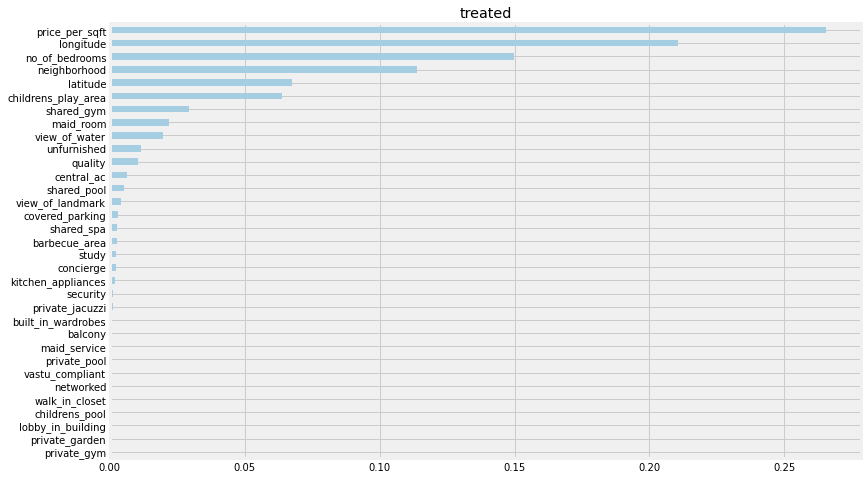

In [ ]:
# Using the feature_importances_ method in the base learner (LGBMRegressor() in this example)
slearner.plot_importance(X=X, tau=slearner_tau, features=feature_names, normalize=True, method='auto')

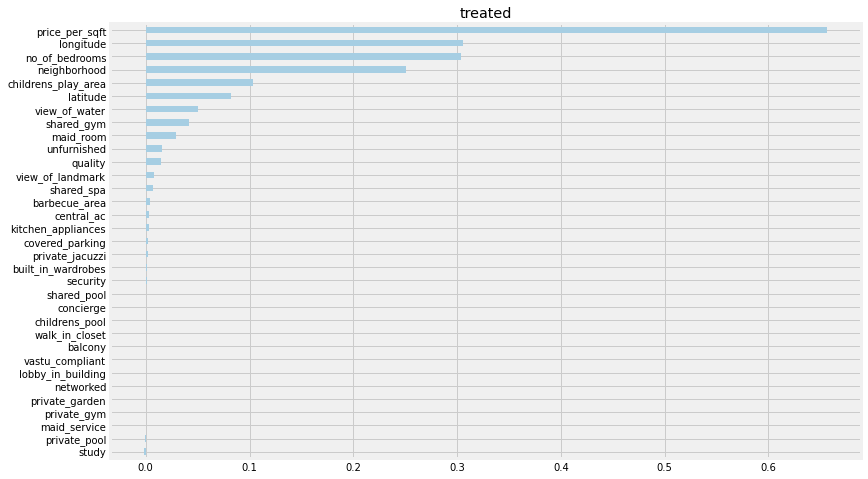

In [ ]:
# Using eli5's PermutationImportance
slearner.plot_importance(X=X, tau=slearner_tau, normalize=True, features=feature_names, method='permutation')

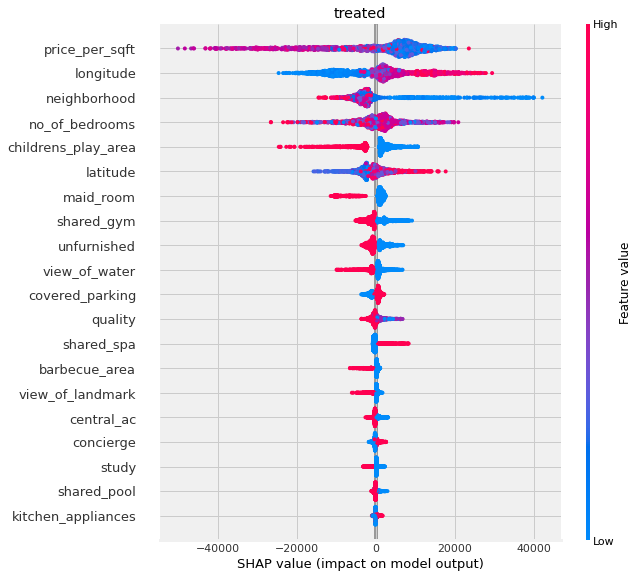

In [ ]:
# Using SHAP
shap_slearner = slearner.get_shap_values(X=X, tau=slearner_tau)
# Plot shap values without specifying shap_dict
slearner.plot_shap_values(X=X, tau=slearner_tau, features=feature_names)

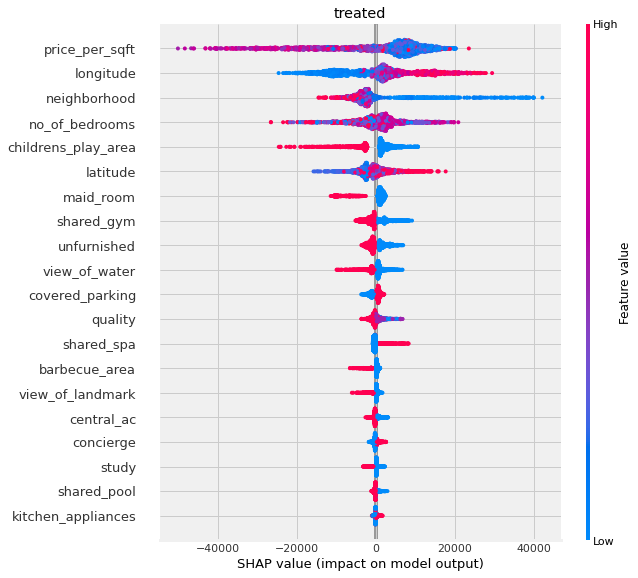

In [ ]:
# Plot shap values WITH specifying shap_dict
slearner.plot_shap_values(X=X, shap_dict=shap_slearner, features=feature_names)

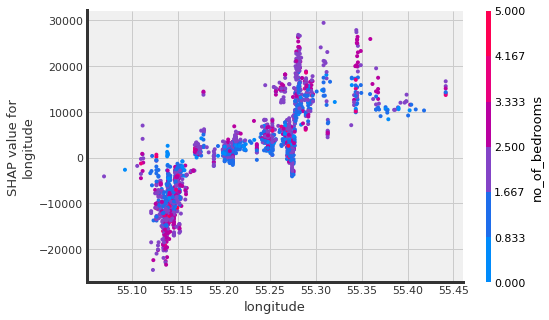

In [ ]:
# interaction_idx set to 'auto' (searches for feature with greatest approximate interaction)
slearner.plot_shap_dependence(treatment_group='treated',
 feature_idx=1,
 X=X,
 tau=slearner_tau,
 features=feature_names,
 interaction_idx='auto')

After receiving the results of the feature importance evaluation tools, we notice that price per square foot, longitude, number of bedrooms and neighboorhod play an important role in determining the price of the house. While most of these predictors make logical sense, longitude might mean that most of the expensive neighborhoods are situated on the same side of the city. 
In addition, shap values might indicate that properties located in lower longitude generally have more bedrooms. 

This concludes the project. Thank you for following along, cheers!